# Classification of Mask - Final Code

### Obtaining & Configuring the dataset (from Google Drive to Computer)

> **PLEASE DO NOT RUN THIS HERE.**

##### Steps:

1. **Use:** `pip install google-api-python-client`.
2. **Please refer to the Google Documentation on OAuth 2.0 & Drive API v3.**
3. **Please enter:** `http://localhost:8080/` as a `redirect_uri` in the cloud console of Google for your Client ID & Secret Pair.
4. **Please set up:** the OAuth 2.0 screen with one of the sensitive scopes as `./auth/drive` for full access to **Google Drive API**.



After registering the client keys please do not forget to download and save `client_secrets.json`, at the same path as your program. That section is uploaded to [https://github.com/formula21/face-mask/blob/main/croppie.py](https://github.com/formula21/face-mask/blob/main/croppie.py).

##### Other notes:

1. The `imagebuffer` once stored as a file, stays on your computer, unless you define the `FLAG_UPLOAD = true` and `FLAG_UPLOAD_PARENT_ID = [None, None] or [str, str]`.
  - If either `None` is defined,  a **new folder** with the names `with_mask` and `without_mask` are created or the id's are used to upload. If a failure of finding the directories in drive, the program terminates with an Exception.
  - If either or both are found, we will send the buffer immediately to upload.
2. By default, the file is supposed to be also saved locally, however this can be omitted by defining `FLAG_DOWNLOAD_AND_SAVE = false`.



### Google Drive Authorization

We are authorizing Google Colab with Google Drive for us to get access to our dataset. This authorization is native to Google's Documentation.

**Please note:** You need to change the variable `dir` below to the appropriate path. If you are using a "Shared With Me" folder please set up a "Add Shortcut to Drive", to set shortcut and get easy access to &ldquo;My Drive&rdquo;.

In [ ]:
from google.colab import drive
import os
 
# Mounting statement
drive.mount('/content/drive', force_remount=True)

# Directory (Please make appropiate changes)

# Please make changes here.
if not os.path.isdir('/content/models'):
  os.mkdir('/content/models')

if not os.path.isdir('/content/plot'):
   os.mkdir('/content/plot')

Mounted at /content/drive


#### Directory

We declare a variable `dir` independently, so that we can change the parent part as and when required.

In [ ]:
dir = '/content/drive/MyDrive/College/Sem 6/Project_FACE_MASK/fm_detector/dataset'

## Section 1 ~ Convoluted Neural Networks

We are introducing here 3 types of CNN to compare between their models.

1. ResNet50
2. DenseNet201
3. MobilenetV2

As most libraries are common, we try to import these all at once.

### Section 1.0: Pre Associating the images

We import all images from the required dir, sort them according to labels and append them to a list. These images can be then passed to the `preprocess_input` function of the individual neural network libraries.

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
# from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

# Initial learning rate, can be extended
intial_learning_rate = 1e-4

# number of epochs to train
epochs = 45 

# The size of the batch to train on
batch_size = 4

categories = ["with_mask", "without_mask"]

img_to_arr = []

for category in categories:
    path = os.path.join(dir, category)
    x = os.listdir(path)
    if category == "without_mask":
       x = x[0:int(0.3 * len(x))]
    for i in range(0, len(x)):
        img = x[i]
        path_img = os.path.join(path, img)
        print("Loading %d out of %d in %s" % ((i+1), len(x), category))
        # see from tensorflow.keras.preprocessing.image import load_img
        image = load_img(path_img, target_size=(224, 224))
        # from tensorflow.keras.preprocessing.image import img_to_array
        image = img_to_array(image)
        # Appending globally to img_to_arr
        img_to_arr.append({"image":image, "category":category})

### Section 1.1: ResNet 50

> ResNet-50 is a convolutional neural network that is 50 layers deep. You can 
> load a pretrained version of the network trained on more than a million 
> images from the ImageNet database. The pretrained network can classify images 
> into 1000 object categories, such as keyboard, mouse, pencil, and many 
> animals.

We have the documentation @ [https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50).



94773248/94765736 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/45
89/89 [==============================] - 88s 607ms/step - loss: 0.2975 - accuracy: 0.9107 - val_loss: 0.1674 - val_accuracy: 0.9535
Epoch 2/45
89/89 [==============================] - 53s 595ms/step - loss: 0.1653 - accuracy: 0.9495 - val_loss: 0.1114 - val_accuracy: 0.9594
Epoch 3/45
89/89 [==============================] - 53s 589ms/step - loss: 0.1618 - accuracy: 0.9472 - val_loss: 0.1083 - val_accuracy: 0.9683
Epoch 4/45
89/89 [==============================] - 53s 590ms/step - loss: 0.1525 - accuracy: 0.9525 - val_loss: 0.1139 - val_accuracy: 0.9604
Epoch 5/45
89/89 [==============================] - 52s 588ms/step - loss: 0.1289 - accuracy: 0.9562 - val_loss: 0.1198 - val_accuracy: 0.9624
Epoch 6/45
89/89 [==============================] - 52s 582ms/step - loss: 0.1432 - accuracy: 0.9537 - val_loss: 0.1085 - val_accuracy: 0.9634
Epoch 7/45
89/89 [==============================] - 52s 588ms/step - loss: 0.1444 - accuracy: 0.9537 - val_loss: 0.1243 - val_accuracy: 0.9644

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


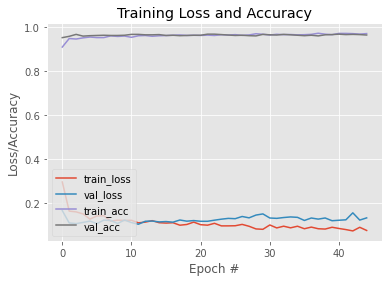

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input

data = []
labels = []

batch_size = 45
intial_learning_rate = 0.003
epoch = 20

for img in img_to_arr:
  image, category = img['image'], img['category']
  # from tensorflow.keras.applications.* import preprocess_input
  image = resnet50_preprocess_input(image)
  # Append the image at index (x)
  data.append(image)
  # Append the label for each image... at an index (x)
  labels.append(category)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels)

# Setting the data (images) to pixels of float32
data = np.array(data, dtype="float32")

# Converting labels to array
labels = np.array(labels)

# Dataset split w.r.t ratio.
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.20, stratify=labels, random_state=42)
# Data Augmentation
# Extra sampling of images.
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

resnet_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_tensor=Input(shape=(224, 224, 3))
)

# construct the head of the model that will be placed on top of the
# the base model
resnet_head_model = resnet_model.output
# 224 / 32 = 7
# Window create -> Shifting
resnet_head_model = AveragePooling2D(pool_size=(7, 7))(resnet_head_model)

# Feature Map flatted to 1D Formation
resnet_head_model = Flatten(name="flatten")(resnet_head_model)

# Action Function = RELU.. (Possibility)... Image Thresholding (Function making)
# Rectified Linear Unit
resnet_head_model = Dense(128, activation="relu")(resnet_head_model)

# Dropout -> 1/2 is expunged [It is a bias]
resnet_head_model = Dropout(0.5)(resnet_head_model)

# Max=[0, MAX] (Binary Classification)
resnet_head_model = Dense(2, activation="softmax")(resnet_head_model)


model = Model(inputs=resnet_model.input, outputs=resnet_head_model)

# Layers
for layer in resnet_model.layers:
    # Freezing so that a pre-set model at transfer learning ....
    layer.trainable = False

# TODO: Explaination needed?
opt = Adam(lr=intial_learning_rate, decay=(intial_learning_rate / epochs))

model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])

# TODO: Explaination needed?
resnet_head = model.fit(
    aug.flow(trainX, trainY, batch_size=batch_size),
    steps_per_epoch=len(trainX) // batch_size,
    validation_data=(testX, testY),
    validation_steps=len(testX) // batch_size,
    epochs=epochs)

# TODO: Explaination needed?
predIdxs = model.predict(testX, batch_size=batch_size)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
# TODO: Explaination needed?
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
# TODO: Explaination needed?
print(classification_report(testY.argmax(axis=1), predIdxs,
                            target_names=lb.classes_))

# Save the model
# evaluate(), save()
models_path = os.path.join(os.path.abspath("models"), "resnet.model")
model.save(models_path, save_format="h5")

N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), resnet_head.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), resnet_head.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), resnet_head.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), resnet_head.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plot_path = os.path.join(os.path.abspath("plot"), "resnet.png")
plt.savefig(plot_path)


### Section 1.2: DenseNet 201


In [ ]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input

data = []
labels = []

# Initial learning rate, can be extended
intial_learning_rate = 1e-4

# number of epochs to train
epochs = 10

batch_size = 18

for img in img_to_arr:
  image, category = img['image'], img['category']
  # from tensorflow.keras.applications.* import preprocess_input
  image = densenet_preprocess_input(image)
  # Append the image at index (x)
  data.append(image)
  # Append the label for each image... at an index (x)
  labels.append(category)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels)

# Setting the data (images) to pixels of float32
data = np.array(data, dtype="float32")

# Converting labels to array
labels = np.array(labels)

# Dataset split w.r.t ratio.
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.20, stratify=labels, random_state=42)
# Data Augmentation
# Extra sampling of images.
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

dense_model = DenseNet201(
    weights="imagenet",
    include_top=False,
    input_tensor=Input(shape=(224, 224, 3))
)

# construct the head of the model that will be placed on top of the
# the base model
dense_head_model = dense_model.output
# 224 / 32 = 7
# Window create -> Shifting
dense_head_model = AveragePooling2D(pool_size=(7, 7))(dense_head_model)

# Feature Map flatted to 1D Formation
dense_head_model = Flatten(name="flatten")(dense_head_model)

# Action Function = RELU.. (Possibility)... Image Thresholding (Function making)
# Rectified Linear Unit
dense_head_model = Dense(128, activation="relu")(dense_head_model)

# Dropout -> 1/2 is expunged [It is a bias]
dense_head_model = Dropout(0.5)(dense_head_model)

# Max=[0, MAX] (Binary Classification)
dense_head_model = Dense(2, activation="softmax")(dense_head_model)


model = Model(inputs=dense_model.input, outputs=dense_head_model)

# Layers
for layer in dense_model.layers:
    # Freezing so that a pre-set model at transfer learning ....
    layer.trainable = False

# TODO: Explaination needed?
opt = Adam(lr=intial_learning_rate, decay=(intial_learning_rate / epochs))

model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])

# TODO: Explaination needed?
dense_head = model.fit(
    aug.flow(trainX, trainY, batch_size=batch_size),
    steps_per_epoch=len(trainX) // batch_size,
    validation_data=(testX, testY),
    validation_steps=len(testX) // batch_size,
    epochs=epochs)

# TODO: Explaination needed?
predIdxs = model.predict(testX, batch_size=batch_size)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
# TODO: Explaination needed?
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
# TODO: Explaination needed?
print(classification_report(testY.argmax(axis=1), predIdxs,
                            target_names=lb.classes_))

# Save the model
# evaluate(), save()
models_path = os.path.join(os.path.abspath("models"), "densenet.model")
model.save(models_path, save_format="h5")

N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), dense_head.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), dense_head.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), dense_head.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), dense_head.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plot_path = os.path.join(os.path.abspath("plot"), "densenet.png")
plt.savefig(plot_path)


### Section 1.3: MobileNet v2


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_v2_preprocess_input

data = []
labels = []

# Initial learning rate, can be extended
intial_learning_rate = 1e-4

# number of epochs to train
epochs = 45

batch_size = 4

for img in img_to_arr:
  image, category = img['image'], img['category']
  # from tensorflow.keras.applications.* import preprocess_input
  image = mobilenet_v2_preprocess_input(image)
  # Append the image at index (x)
  data.append(image)
  # Append the label for each image... at an index (x)
  labels.append(category)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# from tensorflow.keras.utils import to_categorical
labels = to_categorical(labels)

# Setting the data (images) to pixels of float32
data = np.array(data, dtype="float32")

# Converting labels to array
labels = np.array(labels)

# Dataset split w.r.t ratio.
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.20, stratify=labels, random_state=42)
# Data Augmentation
# Extra sampling of images.
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

mobile_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_tensor=Input(shape=(224, 224, 3))
)

# construct the head of the model that will be placed on top of the
# the base model
mobile_head_model = mobile_model.output
# 224 / 32 = 7
# Window create -> Shifting
mobile_head_model = AveragePooling2D(pool_size=(7, 7))(mobile_head_model)

# Feature Map flatted to 1D Formation
mobile_head_model = Flatten(name="flatten")(mobile_head_model)

# Action Function = RELU.. (Possibility)... Image Thresholding (Function making)
# Rectified Linear Unit
mobile_head_model = Dense(128, activation="relu")(mobile_head_model)

# Dropout -> 1/2 is expunged [It is a bias]
mobile_head_model = Dropout(0.5)(mobile_head_model)

# Max=[0, MAX] (Binary Classification)
mobile_head_model = Dense(2, activation="softmax")(mobile_head_model)


model = Model(inputs=mobile_model.input, outputs=mobile_head_model)

# Layers
for layer in mobile_model.layers:
    # Freezing so that a pre-set model at transfer learning ....
    layer.trainable = False

# TODO: Explaination needed?
opt = Adam(lr=intial_learning_rate, decay=(intial_learning_rate / epochs))

model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])

# TODO: Explaination needed?
mobile_head = model.fit(
    aug.flow(trainX, trainY, batch_size=batch_size),
    steps_per_epoch=len(trainX) // batch_size,
    validation_data=(testX, testY),
    validation_steps=len(testX) // batch_size,
    epochs=epochs)

# TODO: Explaination needed?
predIdxs = model.predict(testX, batch_size=batch_size)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
# TODO: Explaination needed?
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
# TODO: Explaination needed?
print(classification_report(testY.argmax(axis=1), predIdxs,
                            target_names=lb.classes_))

# Save the model
# evaluate(), save()
models_path = os.path.join(os.path.abspath("models"), "mobilenet.model")
model.save(models_path, save_format="h5")

N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), mobile_head.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), mobile_head.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), mobile_head.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), mobile_head.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plot_path = os.path.join(os.path.abspath("plot"), "mobilenet.png")
plt.savefig(plot_path)
